# 版权声明

版权 © 2023 斯坦福大厨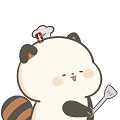，华中科技大学微纳材料设计与制造研究中心的科研工作者。

恭喜您已经发现了这份神奇的计算材料学课件！这份课件是我在熬夜吃掉不计其数的披萨和咖啡后创作出来的，配套的教材是由单斌、陈征征、陈蓉合著的《计算材料学-从算法原理到代码实现》。学习资料合集您可以在这个网址找到：[www.materialssimulation.com/book](www.materialssimulation.com/book)。希望它能帮您在计算材料学的道路上摔得不那么痛。

就像您尊重那些一边烘焙披萨一边写代码的大厨一样，当您使用这份课件时，请：

- 记得告诉大家这份课件是斯坦福大厨写的，并且他在华中科技大学微纳中心工作
- 别用它去赚大钱，这个课件是用来学习的，不是用来买披萨的
- 保持开放共享的精神

如果你有关于计算材料学的想法，或者你只是想和我讨论最好吃的披萨口味，欢迎通过邮件 bshan@mail.hust.edu.cn 联系我。
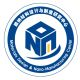

## 1. 一维谐振子运动方程

在这个notebook里，我们将用verlet算法对于一维谐振子的运动进行积分。由于一维谐振子有解析解，所以我们可以将数值积分的结果与解析形式相比对，从而对误差积累，算法稳定性等有一个直观的认识。一维谐振子的解析解如下：

1. 位置:

   $x(t) = x_0 \cos(wt) + \frac{v_0}{w} \sin(wt)$

2. 速度:

   $v(t) = -x_0 w \sin(wt) + v_0 \cos(wt)$

where,
$w = \sqrt{\frac{k}{m}}$


我们首先定义一个HarmonicOscillator的类，用于描述谐振子：

In [ ]:
import numpy as np

class HarmonicOscillator:
    def __init__(self, k, m):
        self.k = k
        self.m = m

    def acceleration(self, x):
        return -self.k * x / self.m

    def analytical_solution(self, x0, v0, t):
        """
        Calculate the analytical solution for the 1D harmonic oscillator.

        Parameters:
        x0 : float
            Initial position.
        v0 : float
            Initial velocity.
        t : float
            Time at which to calculate the position and velocity.

        Returns:
        x : float
            Position at time t.
        v : float
            Velocity at time t.
        """
        w = np.sqrt(self.k / self.m)  # angular frequency
        x = x0 * np.cos(w*t) + v0/w * np.sin(w*t)
        v = -x0 * w * np.sin(w*t) + v0 * np.cos(w*t)
        return x, v


我们可以用这样的方法来创建一个HarmonicOscillator实例，它的acceleration函数会告诉你谐振子处在位置x处的加速度

In [ ]:
# Set up the system
k = 1.0  # spring constant
m = 1.0  # mass
oscillator = HarmonicOscillator(k, m)
oscillator.acceleration(1.0)

-1.0

### 2. Velocity Verlet积分器

Velocity Verlet算法是一种常用于分子动力学模拟的数值积分方法。它是基于Verlet算法的一个变种，但相较于原始的Verlet算法，Velocity Verlet算法在每一步的计算中显式地包含了速度。

Velocity Verlet算法的工作原理如下：它首先根据当前位置和速度计算出下一时刻的位置，然后再根据新的位置计算出下一时刻的加速度，最后再用新的加速度和旧的加速度的平均值来更新速度。这种“分步”或“交错”的更新策略是Velocity Verlet算法得名的原因。

Velocity Verlet算法的一个重要特性是它是辛结构（symplectic），这意味着它在积分过程中保守了哈密顿系统的相应结构，使得在长时间的积分过程中，系统的能量得以良好的保存。这是在分子动力学模拟等需要精确模拟物理系统动力学的场合中，Velocity Verlet算法被广泛使用的原因。

接下来我们将Velocity Verlet积分算法封装在VelocityVerletIntegrator类里，算法的时间更新步如下：


$$step 1: v(t + dt/2) = v(t) + 0.5 * a(t) * dt$$

$$step 2:x(t + dt) = x(t) + v(t + dt/2) * dt$$

$$step 3: a(t + dt) \quad from \quad x(t+dt)$$

$$step 4: v(t + dt) = v(t + dt/2) + 0.5 * a(t + dt) * dt$$

Velocity Verlet基本的算法过程如下图所示：

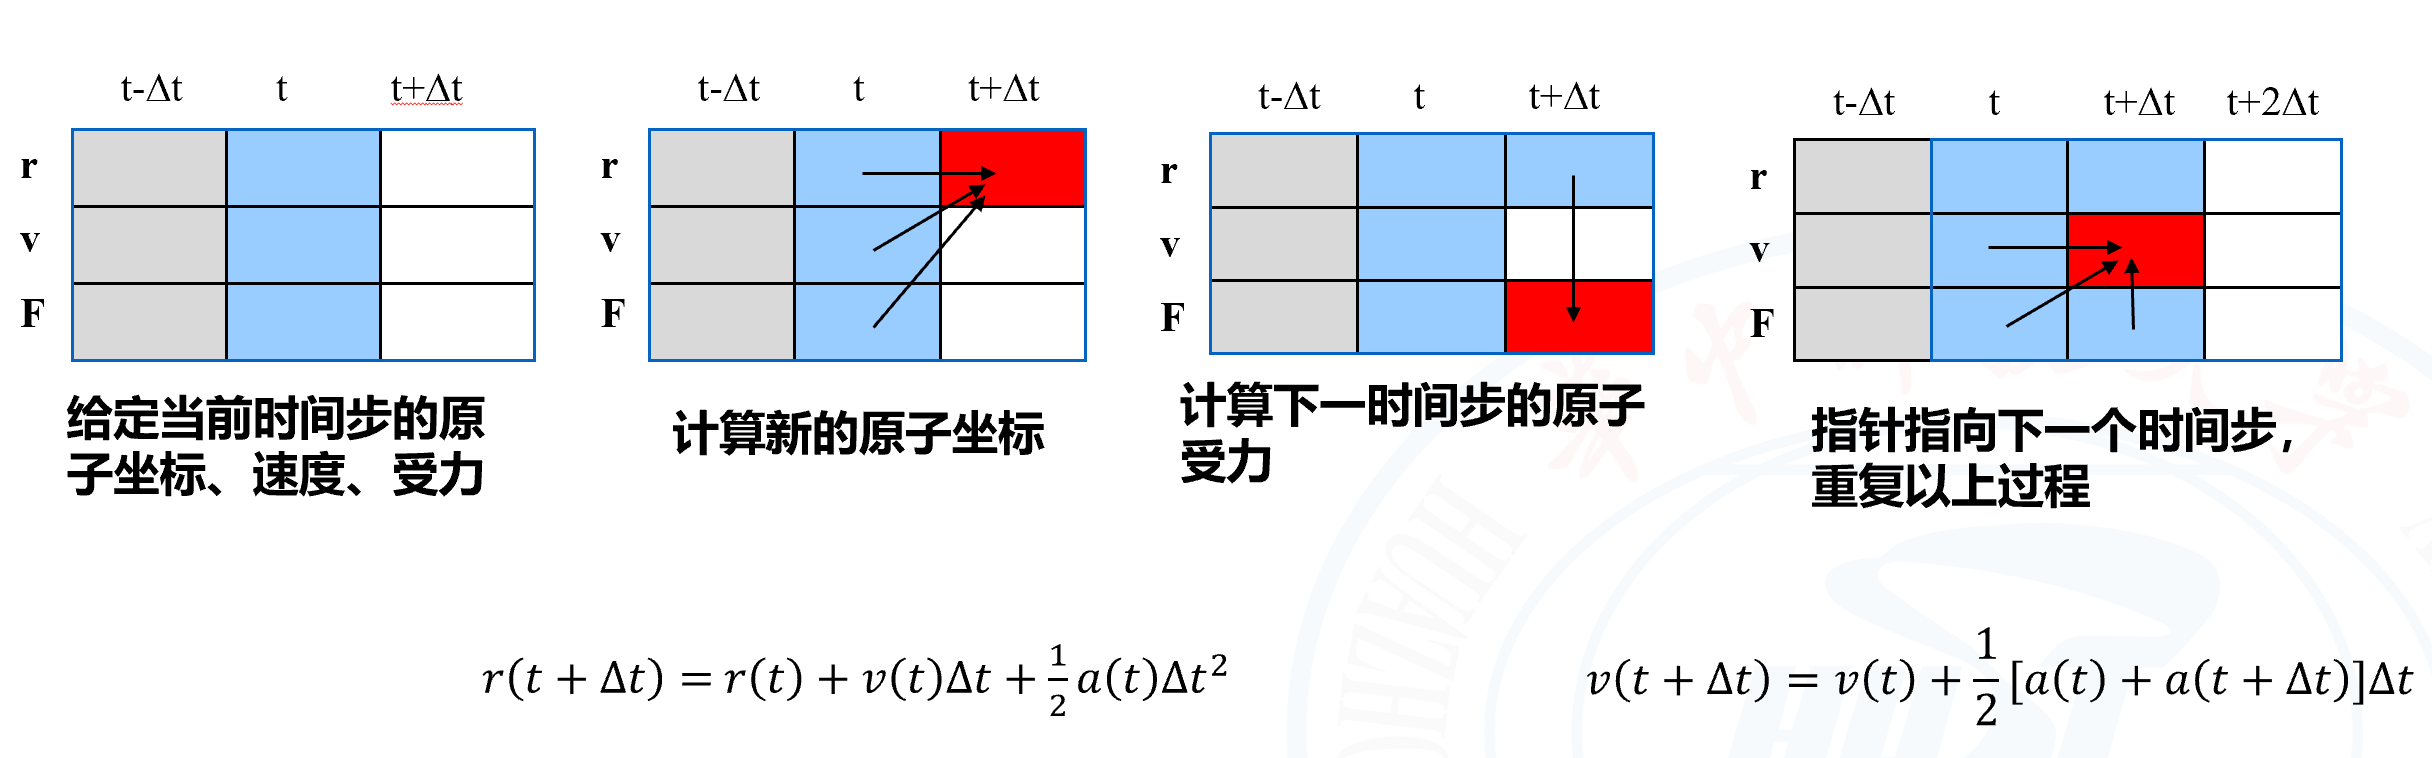

In [ ]:
class VelocityVerletIntegrator:
    """
    A numerical integrator using the Velocity Verlet method.
    """

    def __init__(self, dt):
        """
        Initialize the integrator.

        Parameters:
        dt : float
            Time step for the numerical integration.
        """
        self.dt = dt

    def step(self, system, x, v):
        """
        Perform one integration step.

        Parameters:
        system : object
            The physical system to be integrated. It should have a method `acceleration(x)` that computes the acceleration.
        x : float
            Current position.
        v : float
            Current velocity.

        Returns:
        float, float
            Updated position and velocity.
        """
        a = system.acceleration(x)
        x_new = x + self.dt * v + 0.5 * self.dt**2 * a
        a_new = system.acceleration(x_new)
        v_new = v + 0.5 * self.dt * (a + a_new)

        return x_new, v_new


## 3. 用Velocity Verlet积分方法求解一维谐振子运动

我们首先定义一个用于可视化轨迹的plot_results函数

In [ ]:
import matplotlib.pyplot as plt

def plot_results(times, positions, velocities):
    """
    Plot the time evolution of position and phase space trajectory.

    This function generates two subplots: one showing the position as a function
    of time, and one showing the phase space trajectory (velocity vs. position).

    Parameters:
    times : list of float
        List of times at which the position and velocity were recorded.
    positions : list of float
        List of positions of the harmonic oscillator at the corresponding times.
    velocities : list of float
        List of velocities of the harmonic oscillator at the corresponding times.

    Returns:
    None
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(times, positions)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title('Time Evolution of Position')

    ax2.plot(positions, velocities)
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Velocity')
    ax2.set_title('Phase Space Trajectory')

    plt.tight_layout()
    plt.show()


接下来我们用dt=0.01的步长进行1000步的Velocity Verlet积分运算

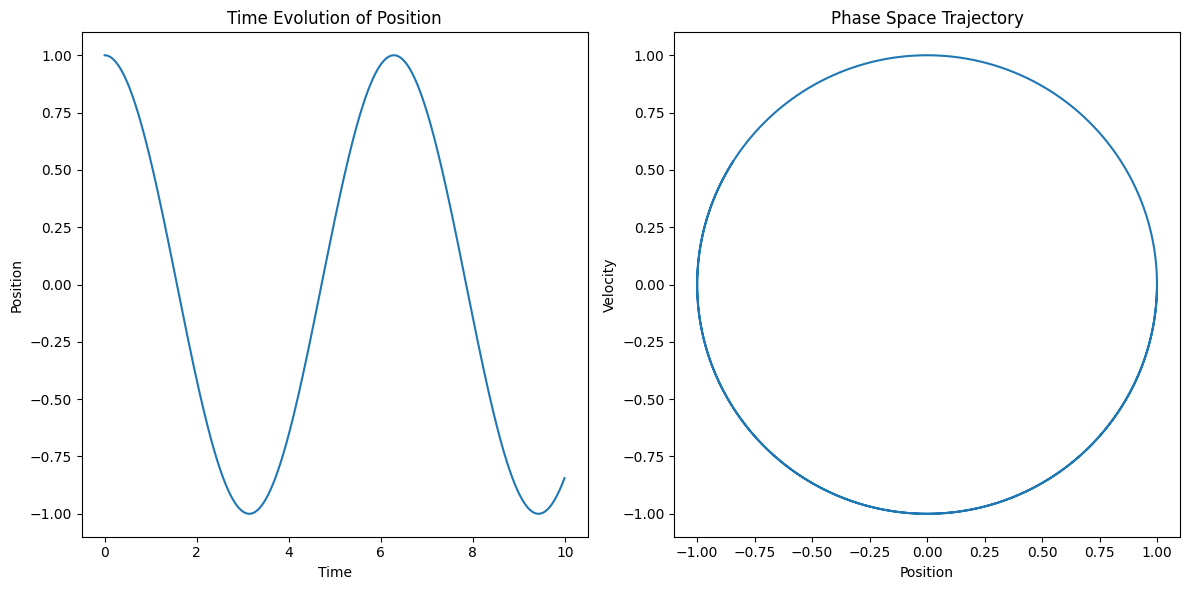

In [ ]:
import math

def main():
    # Set up the system
    k = 1.0  # spring constant
    m = 1.0  # mass
    oscillator = HarmonicOscillator(k, m)

    # Set up the integrator
    dt = 0.01  # time step
    integrator = VelocityVerletIntegrator(dt)

    # Initial conditions
    x = 1.0  # initial position
    v = 0.0  # initial velocity

    # Lists to store time, positions, and velocities
    times = []
    positions = []
    velocities = []

    # Time evolution
    for i in range(1000):
        times.append(i * dt)
        positions.append(x)
        velocities.append(v)
        x, v = integrator.step(oscillator, x, v)


    plot_results(times, positions, velocities)

if __name__ == "__main__":
    main()


上图展示了一维谐振子的位置和速度随时间变化的图像，当积分步长为$\Delta t=0.01$时，Velocity Verlet算法表现出了很好的稳定性。通过$r(t)$的振幅图可以看出，Velocity Verlet算法能够很好地维持正弦或余弦函数的振荡模式，并且振幅随时间保持恒定。同时，$r(t)\sim v(t)$图形成了一个封闭的圆环，这与理论上一维谐振子的相空间区域完全吻合，说明Velocity Verlet算法能够很好地保持系统动力学的守恒性质。